In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import matplotlib as plt
import time

from model import CustomResNet, ConvBlock
from torchvision.models.resnet import BasicBlock, Bottleneck

from torchvision.datasets import CIFAR10, CIFAR100
from torchvision.transforms import ToTensor, Compose, RandomCrop, RandomHorizontalFlip, Normalize
from torch.utils.data import DataLoader, random_split
from torch.optim import SGD, lr_scheduler
from tqdm import tqdm

dataset_name = 'cifar10'
teacher_name = 'resnet56_baseline'
student_name = 'resnet56_recast'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_class = 10
batch_size = 64
epoch = 60
lr = 0.001
step_size = 20

mse_loss = nn.MSELoss()
criterion = nn.CrossEntropyLoss()

In [2]:
transform = Compose([
    ToTensor(),
    RandomCrop(size=[32, 32], padding=4),
    RandomHorizontalFlip(p=0.5),
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])

transform_test = Compose([
    ToTensor(),
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])

train_dataset = CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = CIFAR10(root='./data', train=False, transform=transform_test, download=True)

# DataLoader 정의
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 데이터셋 확인
print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(test_dataset)}')

Files already downloaded and verified
Files already downloaded and verified
Train dataset size: 50000
Validation dataset size: 10000


In [3]:
teacher = CustomResNet(block=BasicBlock,
                   layers=[9, 9, 9],
                   num_classes=10).to(device).eval()
# checkpoint = torch.load(f'./result/{dataset_name}_{teacher_name}.pt')
# teacher.load_state_dict(checkpoint['model'])

total_params = sum(p.numel() for p in teacher.parameters())
print(f'Total number of parameters: {total_params}')
print(teacher)

Total number of parameters: 855770
CustomResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layers): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3),

In [4]:
student = CustomResNet(block=BasicBlock,
                   layers=[9, 9, 9],
                   num_classes=10).to(device)
checkpoint = torch.load(f'./result/{dataset_name}_{teacher_name}.pt')
student.load_state_dict(checkpoint['model'])

total_params = sum(p.numel() for p in student.parameters())
print(f'Total number of parameters: {total_params}')
print(student)

Total number of parameters: 855770
CustomResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layers): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3),

In [5]:
history = dict()
for idx in range(len(student.layers)):
    history[idx] = dict(train_loss=[], test_acc=[], train_time=[], test_time=[])
    
    # recasting
    print(f'block {idx} recasting...')
    target_block = student.layers[idx]
    in_channels = target_block.conv1.in_channels
    stride = target_block.conv1.stride
    out_channels = target_block.conv2.out_channels
    
    student.layers[idx] = ConvBlock(in_channels, out_channels, stride).to(device)
    for m in student.layers[idx].modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.xavier_uniform_(m.weight)
        elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

    params = []
    for i in range(idx + 1):
        params.extend(student.layers[i].parameters())
    optimizer = torch.optim.Adam(params, lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size)

    print(f'block {idx} training started...')
    for ep in range(epoch):
        # train step
        train_loss = 0.0
        student.train()
        s_time = time.time()
        for i, (image, _) in enumerate(train_loader):
            image = image.to(device)

            target = teacher(image, idx)
            pred = student(image, idx)

            loss = mse_loss(pred, target)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        e_time = time.time()
        history[idx]['train_loss'].append(train_loss/len(train_loader))
        history[idx]['train_time'].append(e_time - s_time)

        # test step
        test_acc = 0.0
        student.eval()
        s_time = time.time()
        for image, target in test_loader:
            image = image.to(device)
            target = f.one_hot(target, 10).float().to(device)

            pred = student(image)
            test_acc += torch.sum(torch.argmax(pred, dim=1) == torch.argmax(target, dim=1)).item()
        e_time = time.time()
        history[idx]['test_acc'].append(test_acc/len(test_dataset))
        history[idx]['test_time'].append(e_time - s_time)
        print(f'epoch={ep:d}, train_loss={train_loss/len(train_loader):.4f}, test_acc={test_acc/len(test_dataset):.4f}')

        checkpoint = dict(
            model=student.state_dict(),
            optimizer=optimizer.state_dict(),
            history=history,
            epoch=ep
        )
        torch.save(checkpoint, f'./result/{dataset_name}_{student_name}.pt')
        scheduler.step()

block 0 recasting...
block 0 training started...
epoch=0, train_loss=0.3284, test_acc=0.8994
epoch=1, train_loss=0.1015, test_acc=0.9125
epoch=2, train_loss=0.0434, test_acc=0.9156
epoch=3, train_loss=0.0241, test_acc=0.9209
epoch=4, train_loss=0.0167, test_acc=0.9250
epoch=5, train_loss=0.0110, test_acc=0.9267
epoch=6, train_loss=0.0078, test_acc=0.9275
epoch=7, train_loss=0.0076, test_acc=0.9289
epoch=8, train_loss=0.0075, test_acc=0.9277
epoch=9, train_loss=0.0075, test_acc=0.9288
epoch=10, train_loss=0.0075, test_acc=0.9283
epoch=11, train_loss=0.0074, test_acc=0.9283
epoch=12, train_loss=0.0073, test_acc=0.9283
epoch=13, train_loss=0.0074, test_acc=0.9285
epoch=14, train_loss=0.0075, test_acc=0.9276
epoch=15, train_loss=0.0073, test_acc=0.9280
epoch=16, train_loss=0.0073, test_acc=0.9278
epoch=17, train_loss=0.0074, test_acc=0.9278
epoch=18, train_loss=0.0075, test_acc=0.9288
epoch=19, train_loss=0.0073, test_acc=0.9277
epoch=20, train_loss=0.0072, test_acc=0.9279
epoch=21, train_

Total number of parameters: 415546
CustomResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layers): Sequential(
    (0): ConvBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ConvBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): ConvBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplac

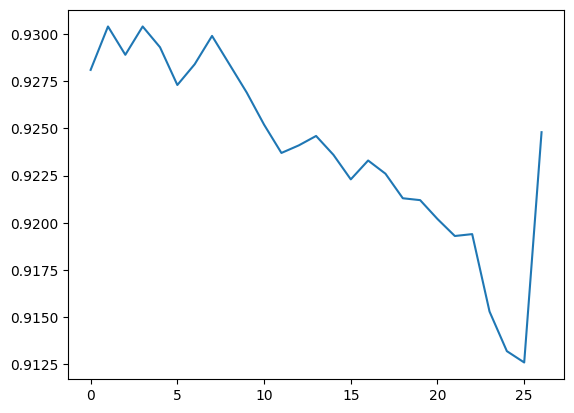

In [4]:
import matplotlib.pyplot as plt
import numpy as np

student = CustomResNet(block=ConvBlock,
                   layers=[9, 9, 9],
                   num_classes=num_class).to(device)
checkpoint = torch.load(f'./result/{dataset_name}_{student_name}.pt')
student.load_state_dict(checkpoint['model'])

total_params = sum(p.numel() for p in student.parameters())
print(f'Total number of parameters: {total_params}')
print(student)

checkpoint['history'][0]['test_acc']

x = np.arange(len(checkpoint['history']))
y = list(checkpoint['history'][i]['test_acc'][-1] for i in range(len(checkpoint['history'])))

plt.plot(x, y)
plt.show()